# 0-Libraries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [47]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [48]:
s_aureus = pd.read_csv('s_aureus_driams_a_bin3_2000_20000Da.csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19991,19994,19997,code,species,Oxacillin,Clindamycin,Ceftriaxone,Ciprofloxacin,Fusidic acid
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,35.5,20.5,27.342857,029f0abf-1664-424f-88cb-11c9c8af2b11,Staphylococcus aureus,0.0,0.0,0.0,0.0,1.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,30.0,40.5,34.695238,08149af1-10f5-4f02-81d8-3d46d66d4a7a,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,2.5,30.5,11.288462,08fe3876-ecee-4ddc-9aa9-a84f605757f7,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,15.5,8.0,20.057143,0a9fdd4b-7180-47c0-849e-cb32d46da94c,Staphylococcus aureus,0.0,0.0,0.0,0.0,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,25.5,32.0,24.990476,0d82f4c4-473c-49d8-8c85-e3e36e96d047,Staphylococcus aureus,1.0,0.0,1.0,1.0,0.0


# Preprocessing Data

In [49]:
s_aureus_oxacillin = s_aureus.drop(columns=['code','species', 'Clindamycin', 'Ceftriaxone', 'Ciprofloxacin', 'Fusidic acid'])
s_aureus_oxacillin.dropna(axis=0, how="any", inplace=True)

In [50]:
s_aureus_ceftriaxone = s_aureus.drop(columns=['Oxacillin', 'Clindamycin', 'Ceftriaxone', 'Fusidic acid'])
#ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.dropna(axis=0, how="any", inplace=True)
s_aureus_ceftriaxone.shape

(3757, 6003)

In [51]:
s_aureus_oxacillin.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.5,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.5,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.5,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.0,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.0,24.990476,1.0


In [52]:
X = s_aureus_oxacillin.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus_oxacillin.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

In [53]:
s_aureus_oxacillin

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Oxacillin
0,951.428571,826.125000,944.857143,898.428571,1007.714286,936.000000,828.571429,812.000000,782.714286,741.625000,...,14.333333,24.0,68.0,19.0,19.000000,50.0,35.5,20.500000,27.342857,0.0
1,784.714286,701.125000,681.571429,762.142857,737.571429,733.000000,735.857143,659.571429,802.714286,554.375000,...,15.666667,39.0,19.5,42.0,69.666667,31.0,30.0,40.500000,34.695238,0.0
2,50.875000,89.142857,56.142857,151.285714,132.714286,110.428571,47.285714,63.428571,100.375000,52.142857,...,20.666667,17.0,2.0,18.0,18.000000,11.5,2.5,30.500000,11.288462,0.0
3,843.285714,816.500000,734.428571,1027.142857,979.428571,875.571429,912.142857,714.428571,945.428571,886.500000,...,22.333333,33.0,29.0,14.5,21.666667,24.5,15.5,8.000000,20.057143,0.0
4,307.857143,295.000000,246.714286,181.571429,258.000000,318.714286,295.714286,300.857143,278.142857,256.125000,...,26.666667,25.5,18.0,53.5,23.000000,24.5,25.5,32.000000,24.990476,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3786,288.000000,330.285714,296.142857,265.142857,310.750000,287.000000,345.000000,260.000000,198.714286,257.285714,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.004038,0.0
3787,1286.142857,989.714286,938.285714,901.428571,872.000000,1001.000000,1061.571429,890.857143,813.857143,961.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.053908,0.0
3788,986.857143,977.285714,892.285714,986.714286,1045.875000,986.857143,963.571429,968.571429,960.857143,969.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.039084,0.0
3789,141.857143,197.428571,148.142857,114.000000,125.857143,158.750000,176.571429,148.285714,149.714286,151.714286,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.012113,0.0


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

## Enfoque en clase minoritaria

In [55]:
minority_class = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].drop(columns=['Oxacillin'])


In [56]:
etiquetas = s_aureus_oxacillin[s_aureus_oxacillin['Oxacillin'] == 1].iloc[:, 6000].values

Diffusion model


In [57]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [117]:
torch.manual_seed(42)
np.random.seed(42)

In [118]:
# Preprocesamiento
scaler = StandardScaler()
scaled_data = scaler.fit_transform(minority_class.values)

In [119]:
# Modelo de Difusión
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(128, input_dim)
        )


    def forward(self, x):
        return self.model(x)


In [120]:
# Función de ruido (Scheduler)
def add_noise(data, timesteps, noise_scale=1.0):
    noise = np.random.normal(0, noise_scale, data.shape) * np.sqrt(timesteps / 100)
    noisy_data = data + noise
    return noisy_data, noise


In [121]:
# Configuración del modelo
input_dim = scaled_data.shape[1]
model = DiffusionModel(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss()  # O Huber Loss


In [122]:
# Scheduler de tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)


In [123]:
# Entrenamiento
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32)
epochs = 2000
losses = []  # Para guardar la pérdida por época

for epoch in range(epochs):
    timesteps = np.random.randint(1, 100)
    noisy_data, noise = add_noise(scaled_data, timesteps)
    noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)
    noise_tensor = torch.tensor(noise, dtype=torch.float32)

    optimizer.zero_grad()
    predicted_noise = model(noisy_data_tensor)
    loss = loss_fn(predicted_noise, noise_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Actualiza la tasa de aprendizaje

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item()}")


Epoch 0/2000 - Loss: 0.3218405246734619
Epoch 100/2000 - Loss: 0.3900016248226166
Epoch 200/2000 - Loss: 0.23122785985469818
Epoch 300/2000 - Loss: 0.09456412494182587
Epoch 400/2000 - Loss: 0.05980793759226799
Epoch 500/2000 - Loss: 0.07495265454053879
Epoch 600/2000 - Loss: 0.08952850103378296
Epoch 700/2000 - Loss: 0.06991232186555862
Epoch 800/2000 - Loss: 0.33132776618003845
Epoch 900/2000 - Loss: 0.3687342405319214
Epoch 1000/2000 - Loss: 0.3002728521823883
Epoch 1100/2000 - Loss: 0.03511995077133179
Epoch 1200/2000 - Loss: 0.21882027387619019
Epoch 1300/2000 - Loss: 0.4127541482448578
Epoch 1400/2000 - Loss: 0.2523411214351654
Epoch 1500/2000 - Loss: 0.41833987832069397
Epoch 1600/2000 - Loss: 0.23577846586704254
Epoch 1700/2000 - Loss: 0.3727565407752991
Epoch 1800/2000 - Loss: 0.2718573808670044
Epoch 1900/2000 - Loss: 0.231329083442688


In [124]:
# Generación de Datos Sintéticos
def generate_synthetic_data(model, num_samples, input_dim):
    model.eval()
    with torch.no_grad():
        synthetic_data = np.random.normal(0, 1, (num_samples, input_dim))
        for t in range(100, 0, -1):  # Reverse diffusion
            synthetic_data = synthetic_data - model(torch.tensor(synthetic_data, dtype=torch.float32)).numpy() * (t / 100)
        return synthetic_data

In [125]:

synthetic_data = generate_synthetic_data(model, pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1], input_dim)
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)


In [126]:
synthetic_data

array([[ 0.12576989, -1.85955307,  1.25388539, ...,  1.7739398 ,
        -0.09121776, -0.78312188],
       [ 1.42836175, -0.57811618, -0.24685268, ...,  0.80564838,
         0.6015159 ,  0.87235073],
       [-2.06981857,  1.12438388,  0.76026143, ...,  0.40971864,
        -0.48753931, -1.21962655],
       ...,
       [ 0.77294588, -1.41691904,  0.88227883, ...,  0.29523695,
        -0.03667586,  0.66659339],
       [ 1.31428988,  1.81647727,  0.58216549, ...,  0.53458703,
        -2.19878585,  0.46017889],
       [-0.46892965, -0.43875509, -0.49428724, ...,  0.0425985 ,
        -0.78977488, -1.48058041]])

In [127]:

# Cambiar el tipo de datos a float32
synthetic_samples_numpy = synthetic_data_rescaled.astype(np.float32)

# Mostrar las muestras generadas
synthetic_samples_numpy

array([[ 1.3161875e+03, -2.9765322e+03,  3.9995425e+03, ...,
         7.5972649e+01,  1.9792164e+01, -1.5845939e+00],
       [ 4.2279268e+03, -2.2199826e+02,  4.0427719e+02, ...,
         4.6207596e+01,  4.2035149e+01,  4.8866112e+01],
       [-3.5917048e+03,  3.4376389e+03,  2.8169851e+03, ...,
         3.4036804e+01,  7.0666752e+00, -1.4887120e+01],
       ...,
       [ 2.7628477e+03, -2.0250608e+03,  3.1092979e+03, ...,
         3.0517666e+01,  2.1543449e+01,  4.2595634e+01],
       [ 3.9729370e+03,  4.9253398e+03,  2.3903269e+03, ...,
         3.7875233e+01, -4.7879738e+01,  3.6305130e+01],
       [-1.3169692e+01,  7.7567680e+01, -1.8849307e+02, ...,
         2.2751617e+01, -2.6378064e+00, -2.2839716e+01]], dtype=float32)

In [128]:
X_train_balanced = np.concatenate((X_train,synthetic_samples_numpy))

In [129]:
array_ones = np.ones(pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])
array_ones = np.asarray(array_ones).astype(np.float32)

In [130]:
y_train_balanced = np.concatenate((y_train, array_ones))


In [131]:
synthetic_data_rescaled.shape

(1870, 6000)

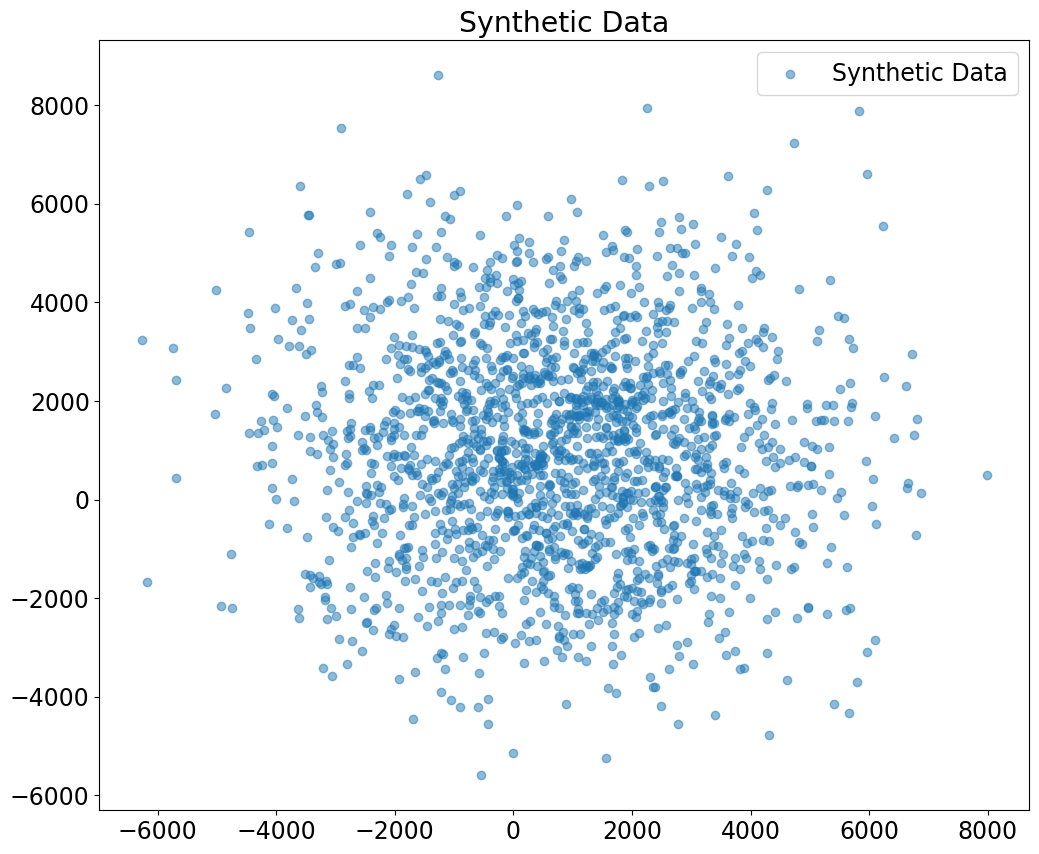

In [132]:
# Visualización
#plt.scatter(minority_class['feature1'], minority_class['feature2'], alpha=0.5, label='Original Data')
plt.scatter(synthetic_data_rescaled[:, 0], synthetic_data_rescaled[:, 1], alpha=0.5, label='Synthetic Data')
plt.legend()
plt.title('Synthetic Data')
plt.show()

## Termino oversampling

In [133]:
len(X)

3790

In [134]:
len(X_train)

3032

In [135]:
len(y_train)

3032

In [136]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [137]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [138]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

# Create and fit DeepAMR model

In [139]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization_12 (Bat  (None, 5984, 64)         256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_13 (Bat  (None, 

In [140]:
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/100
273/273 [==============================] - 10s 25ms/step - loss: 6.1757 - tp: 127.0000 - fp: 104.0000 - tn: 2712.0000 - fn: 543.0000 - accuracy: 0.8144 - precision: 0.5498 - recall: 0.1896 - auc: 0.6760 - prc: 0.4037 - val_loss: 5.7101 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 248.0000 - val_fn: 56.0000 - val_accuracy: 0.8158 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7087 - val_prc: 0.3383 - lr: 1.0000e-04
Epoch 2/100
273/273 [==============================] - 6s 22ms/step - loss: 5.3529 - tp: 45.0000 - fp: 50.0000 - tn: 2153.0000 - fn: 480.0000 - accuracy: 0.8057 - precision: 0.4737 - recall: 0.0857 - auc: 0.6561 - prc: 0.3225 - val_loss: 5.0406 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 248.0000 - val_fn: 56.0000 - val_accuracy: 0.8158 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7755 - val_prc: 0.4541 - lr: 1.0000e-04
Epoch 3/100
273/273 [==============================] - 6s 22ms/step - loss: 4.8127 - tp: 94

# Evaluate the model

In [141]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

24/24 [==============================] - 1s 11ms/step
[[600  13]
 [ 57  88]]


In [142]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.7928446869550543


In [143]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       613
           1       0.87      0.61      0.72       145

    accuracy                           0.91       758
   macro avg       0.89      0.79      0.83       758
weighted avg       0.91      0.91      0.90       758

76/76 [==============================] - 0s 4ms/step
loss :  0.7412504553794861
tp :  88.0
fp :  13.0
tn :  600.0
fn :  57.0
accuracy :  0.9076517224311829
precision :  0.8712871074676514
recall :  0.6068965792655945
auc :  0.900427520275116
prc :  0.8091729879379272



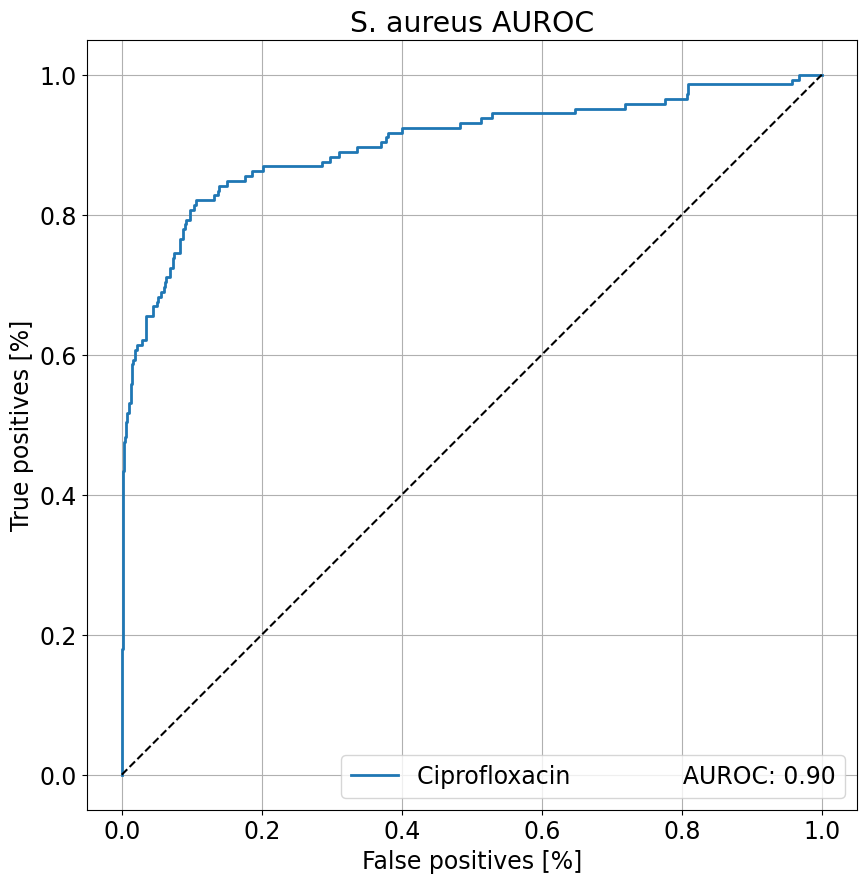

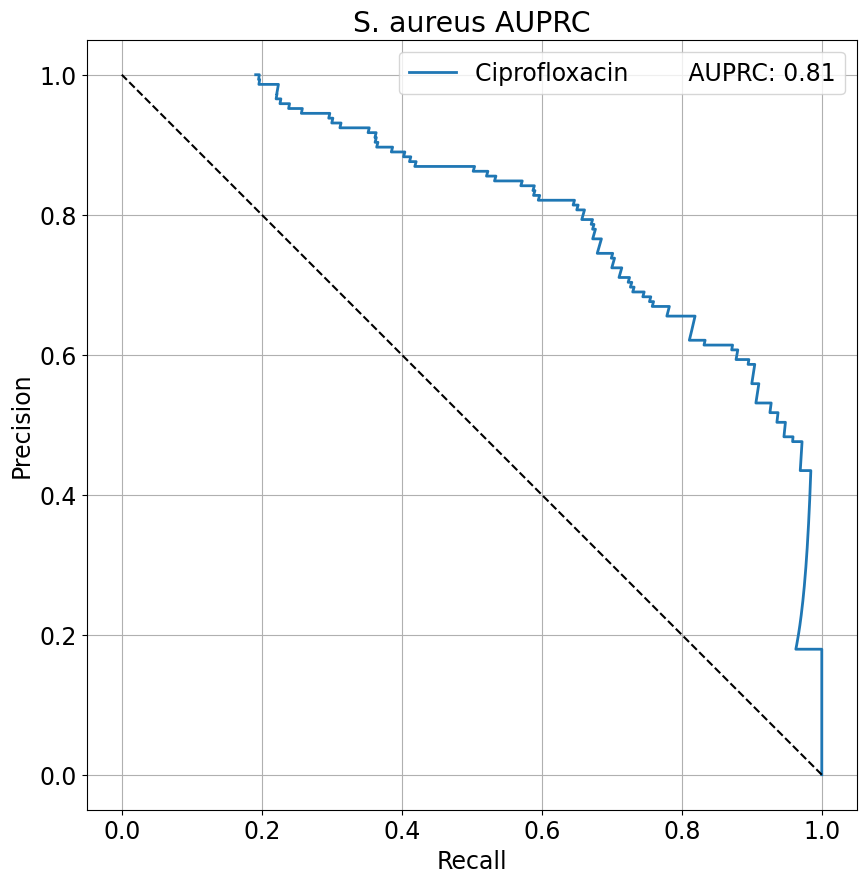

In [144]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()